In [17]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from abm_utils import empirical_prevalence, simulate_abm, create_obs_infer
from utils_local.misc import amro2title, amro2cute


In [18]:
from diagnostic_plots import convergence_plot
from abm_utils import run_amro_synthetic
from utils import create_df_response
from ifeakf import ifeakf

amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']


In [19]:
def mahalanobis_distance(u, v, cov_u):
    """ Mahalanobis distance between a distribution θhat and a point θtruth

    Args:
        u:     Mean of distribution U
        v:     Point
        cov_u: Covariance matrix of U

    Returns:
        _type_: _description_
    """
    return np.sqrt((v - u).T @ np.linalg.inv(cov_u) @ (v - u))

def lin_reg(x, y):
    y    = np.expand_dims(y, -1)
    xreg = np.float64(np.concatenate([np.expand_dims(x, -1), np.ones_like(y)], axis=1))
    p    = np.linalg.inv(xreg.T @ xreg) @ xreg.T @ y
    x    = np.expand_dims(np.linspace(np.around(np.min(x),1), np.max(x), 100), -1)
    x    = np.float64(np.concatenate([x, np.ones_like(x)], axis=1)).T

    yhat = np.squeeze(p.T @ x)

    return x[0,:], yhat


In [20]:
gammas_search = [0.25, 0.5]
betas_search  = [0.01, 0.05, 0.1]
rho_search    = [1/100, 5/100, 10/100, 18/100]

idx_sce = 0
scenarios_large_df = pd.DataFrame(columns=["scenario", "gamma", "beta", "rho"])
for g in gammas_search:
    for b in betas_search:
        for r in rho_search:
            scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
            idx_sce += 1


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60606/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60606/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60606/1486530046.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"

In [21]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_60606/1610801969.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [22]:
from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


id_run      = 5 # 5 is inference with mean trajectory

for idx_row, row in scenarios_large_df.iterrows():
    path_to_samples = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
    if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
        continue

    gamma = row["gamma"]

    print(f"\t Synthetic {idx_row+1}/{len(scenarios_large_df)}", end="\r")
    model_settings["param_truth"]     = [row["rho"], row["beta"]]
    if_settings["adjust_state_space"] = False
    if_settings["shrink_variance"]    = False

    alpha               = 1/120
    init_state          = lambda θ: amr_abm(t = 0,
                                            agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                            gamma          = gamma,
                                            beta           = θ[1, :],
                                            alpha          = alpha,
                                            movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                            ward2size      = ward2size,
                                            model_settings = model_settings)

    process       = lambda t, x, θ: amr_abm(t = t,
                                            agents_state   = x,
                                            gamma          = gamma,
                                            beta           = θ[1, :],
                                            alpha          = alpha,
                                            movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                            ward2size      = ward2size,
                                            model_settings = model_settings)

    obs_model = lambda t, x, θ: observe_cluster_individual(t = t,
                                                            agents_state   = x,
                                                            rho            = θ[0, :],
                                                            movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                            model_settings = model_settings)

    run_amro_synthetic(f               = process,
                        f0             = init_state,
                        g              = obs_model,
                        fsim           = simulate_abm,
                        model_settings = model_settings,
                        if_settings    = if_settings,
                        id_run         = id_run,
                        path_to_save   = path_to_samples,
                        use_mean       = True #use mean observation for inference
                        )


In [23]:

id_run      = 0
distance_df = pd.DataFrame()

for idx_row, row in scenarios_large_df.iterrows():

    path_to_samples = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
    inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

    θpost           = inference["posterior"].mean(-2)[:, :, -1]
    θtruth          = inference["teta_truth"][:, [0]] # [p, 1], Truth (vector column)
    ysim            = inference["observations"]
    yinfer          = ysim[:, :, inference["idx_infer"]]
    Cv              = np.cov(θpost)  # covariance matrix
    θmean           = θpost.mean(-1, keepdims=True) # [p, 1], mean estimate (vector column)


    dist_estimate = mahalanobis_distance(θmean, θtruth, Cv)
    obs_df             = pd.DataFrame(columns=["obs", "mean_obs", "date"])
    obs_df["obs"]      = yinfer.sum(-1).T
    obs_df["mean_obs"] = np.mean(ysim.sum(1), -1).T
    obs_df["date"]     = dates_simulation
    obs_df = obs_df.set_index("date").resample("W").sum()
    dist   = np.sqrt(np.sum((obs_df["obs"] - obs_df["mean_obs"])**2))

    crps_dist = eval_crps(torch.tensor(ysim.sum(1).T), torch.tensor(yinfer.sum(-1).T))

    df            = pd.DataFrame.from_dict({
                                        "scenario": idx_row+1,
                                        "distance_estimate": dist_estimate[0,0],
                                        "distance_obs": crps_dist,
                                        "gamma": row["gamma"],
                                        "beta":  row["beta"],
                                        "rho":   row["rho"]}, orient="index").T

    distance_df = pd.concat([distance_df, df], axis=0, ignore_index=True)

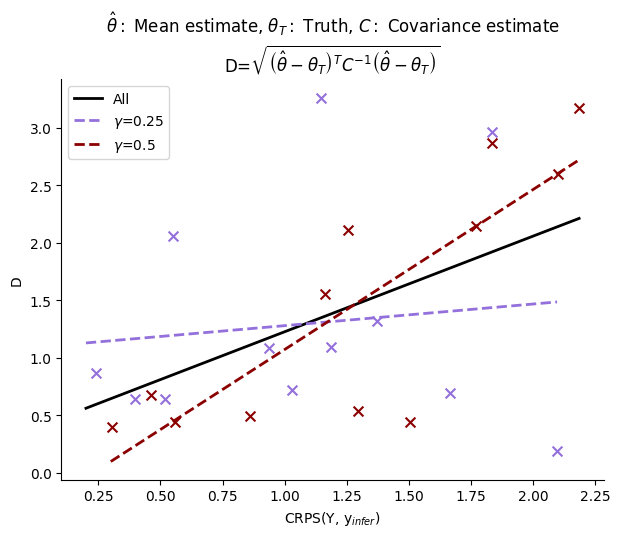

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7, 5.2), sharex=False, sharey=False)

x, ylin = lin_reg(distance_df.distance_obs, distance_df.distance_estimate)
ax.plot(x, ylin, color="k", linestyle="-", label="All", lw=2)

colors = ["mediumpurple", "darkred"]
for idx_g, gamma in enumerate(distance_df.gamma.unique()):
    d_df = distance_df[distance_df.gamma==gamma]
    ax.scatter(d_df.distance_obs, d_df.distance_estimate, color=colors[idx_g], marker="x", s=50)
    x, ylin = lin_reg(d_df.distance_obs, d_df.distance_estimate)
    ax.plot(x, ylin, color=colors[idx_g], label=rf"$\gamma$={gamma}", lw=2, ls="--")

ax.set_title(r"$\hat{\theta}:$ Mean estimate, $\theta_T:$ Truth, $C:$ Covariance estimate"+"\n"+
            r"D=$\sqrt{\left(\hat{\theta}-\theta_T\right)^TC^{-1}\left(\hat{{\theta}}-\theta_T\right)}$")
ax.set_xlabel(r"CRPS(Y, y$_{infer}$)")
ax.set_ylabel("D")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

fig.savefig(os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", "distance_estimate_vs_crpsObs.png"), dpi=300, bbox_inches="tight")

In [27]:

id_run           = 5
distance_mean_df = pd.DataFrame()

for idx_row, row in scenarios_large_df.iterrows():

    path_to_samples = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
    inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

    θpost           = inference["posterior"].mean(-2)[:, :, -1]
    θtruth          = inference["teta_truth"][:, [0]] # [p, 1], Truth (vector column)
    ysim            = inference["observations"]
    yinfer          = ysim[:, :, :].mean(-1)
    Cv              = np.cov(θpost)  # covariance matrix
    θmean           = θpost.mean(-1, keepdims=True) # [p, 1], mean estimate (vector column)


    dist_estimate = mahalanobis_distance(θmean, θtruth, Cv)
    obs_df             = pd.DataFrame(columns=["obs", "mean_obs", "date"])
    obs_df["obs"]      = yinfer.sum(-1).T
    obs_df["mean_obs"] = np.mean(ysim.sum(1), -1).T
    obs_df["date"]     = dates_simulation
    obs_df = obs_df.set_index("date").resample("W").sum()
    dist   = np.sqrt(np.sum((obs_df["obs"] - obs_df["mean_obs"])**2))

    crps_dist = eval_crps(torch.tensor(ysim.sum(1).T), torch.tensor(yinfer.sum(-1).T))

    df            = pd.DataFrame.from_dict({
                                        "scenario":          idx_row+1,
                                        "distance_estimate": dist_estimate[0,0],
                                        "distance_obs":      crps_dist,
                                        "gamma":             row["gamma"],
                                        "beta":              row["beta"],
                                        "rho":               row["rho"]}, orient="index").T

    distance_mean_df = pd.concat([distance_mean_df, df], axis=0, ignore_index=True)

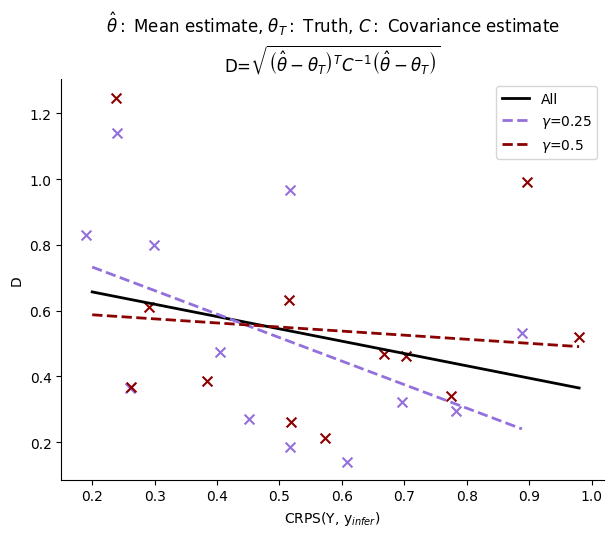

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7, 5.2), sharex=False, sharey=False)

x, ylin = lin_reg(distance_mean_df.distance_obs, distance_mean_df.distance_estimate)
ax.plot(x, ylin, color="k", linestyle="-", label="All", lw=2)

colors = ["mediumpurple", "darkred"]
for idx_g, gamma in enumerate(distance_mean_df.gamma.unique()):
    d_df = distance_mean_df[distance_mean_df.gamma==gamma]
    ax.scatter(d_df.distance_obs, d_df.distance_estimate, color=colors[idx_g], marker="x", s=50)
    x, ylin = lin_reg(d_df.distance_obs, d_df.distance_estimate)
    ax.plot(x, ylin, color=colors[idx_g], label=rf"$\gamma$={gamma}", lw=2, ls="--")

ax.set_title(r"$\hat{\theta}:$ Mean estimate, $\theta_T:$ Truth, $C:$ Covariance estimate"+"\n"+
            r"D=$\sqrt{\left(\hat{\theta}-\theta_T\right)^TC^{-1}\left(\hat{{\theta}}-\theta_T\right)}$")
ax.set_xlabel(r"CRPS(Y, y$_{infer}$)")
ax.set_ylabel("D")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()


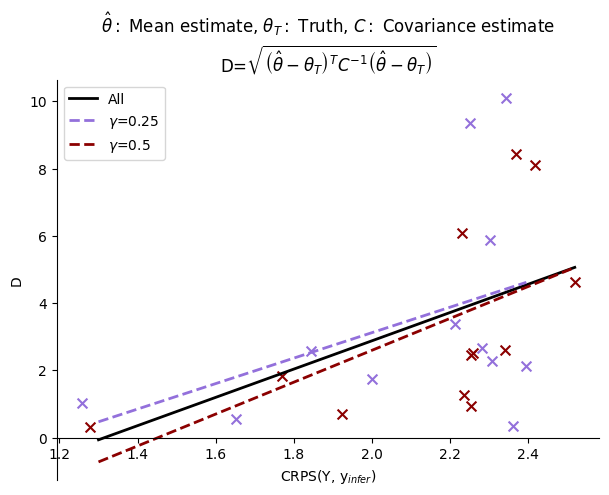

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7, 5.2), sharex=False, sharey=False)


x, ylin = lin_reg(distance_df.distance_obs / distance_mean_df.distance_obs,
                  distance_df.distance_estimate / distance_mean_df.distance_estimate)
ax.plot(x, ylin, color="k", linestyle="-", label="All", lw=2)

colors = ["mediumpurple", "darkred"]
for idx_g, gamma in enumerate(distance_mean_df.gamma.unique()):
    d_df      = distance_df[distance_df.gamma==gamma]
    d_mean_df = distance_mean_df[distance_mean_df.gamma==gamma]

    x = d_df.distance_obs / d_mean_df.distance_obs
    y = d_df.distance_estimate / d_mean_df.distance_estimate

    ax.scatter(x = x,
               y = y,
               color=colors[idx_g], marker="x", s=50)

    x, ylin = lin_reg(x, y)

    ax.plot(x, ylin, color=colors[idx_g], label=rf"$\gamma$={gamma}", lw=2, ls="--")

ax.set_title(r"$\hat{\theta}:$ Mean estimate, $\theta_T:$ Truth, $C:$ Covariance estimate"+"\n"+
            r"D=$\sqrt{\left(\hat{\theta}-\theta_T\right)^TC^{-1}\left(\hat{{\theta}}-\theta_T\right)}$")
ax.set_xlabel(r"CRPS(Y, y$_{infer}$)")
ax.set_ylabel("D")

# set the y-spine
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
